# Hướng dẫn pipeline Faster RCNN (MVTec Bottle)

Notebook này tóm tắt toàn bộ quy trình từ cài đặt, chuẩn bị dữ liệu, training, inference cho tới đánh giá kết quả.


## Nội dung chính
1. Cài đặt & kiểm tra môi trường
2. Chuẩn bị dataset balanced
3. Training model
4. Inference & trực quan hóa
5. Đánh giá kết quả


## 1. Cài đặt & kiểm tra môi trường
Các package chính nằm trong `requirements_fasterrcnn.txt`. Có thể kích hoạt virtualenv (`source venv/bin/activate`).


In [ ]:
# Kiểm tra phiên bản Python và các thư viện chính
import sys, torch, torchvision
print('Python version:', sys.version)
print('Torch version:', torch.__version__, '| CUDA available:', torch.cuda.is_available())
print('Torchvision version:', torchvision.__version__)


Python version: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.3.19.1)]
Torch version: 2.9.0 | CUDA available: False
Torchvision version: 0.24.0


In [ ]:
# Cài đặt nhanh các dependency (chạy nếu cần)
# !pip install -r requirements_fasterrcnn.txt


## 2. Chuẩn bị dataset balanced
Script `prepare_balanced_dataset.py` gom ảnh good + defect rồi chia train/val cân bằng.


In [ ]:
# Thực thi script chuẩn bị dữ liệu (bỏ comment để chạy thật)
prep_cmd = [
    'python', 'prepare_balanced_dataset.py',
    '--source', 'datasets/mvtec/bottle',
    '--output', 'datasets/mvtec_balanced/bottle',
    '--train_ratio', '0.7',
    '--seed', '42'
]
print(' '.join(prep_cmd))
# import subprocess
# subprocess.run(prep_cmd, check=True)


python prepare_balanced_dataset.py --source datasets/mvtec/bottle --output datasets/mvtec_balanced/bottle --train_ratio 0.7 --seed 42


In [ ]:
# Thống kê nhanh số lượng ảnh sau khi chuẩn bị
import os
from collections import Counter
root = 'datasets/mvtec_balanced/bottle'
stats = {}
for split in ['train', 'val']:
    counts = Counter()
    for cls in ['good', 'defect']:
        cls_dir = os.path.join(root, split, cls)
        if os.path.exists(cls_dir):
            counts[cls] = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    stats[split] = counts
stats


{'train': Counter({'good': 153, 'defect': 21}),
 'val': Counter({'good': 68, 'defect': 10})}

## 3. Training model
Model nằm trong `model.py` (ResNet50 backbone hoặc FPN). Script train chính: `train_balanced.py`.


In [ ]:
# Ví dụ lệnh training đầy đủ
train_cmd = [
    'python', 'train_balanced.py',
    '--data_root', 'datasets/mvtec_balanced/bottle',
    '--model_type', 'resnet50',
    '--epochs', '30',
    '--batch_size', '16',
    '--lr', '0.001',
    '--save_dir', 'runs/fasterrcnn_balanced'
]
print(' '.join(train_cmd))
# import subprocess
# subprocess.run(train_cmd, check=True)


python train_balanced.py --data_root datasets/mvtec_balanced/bottle --model_type resnet50 --epochs 30 --batch_size 16 --lr 0.001 --save_dir runs/fasterrcnn_balanced


In [ ]:
# Xem thư mục run mới nhất (nếu đã train)
import glob
run_dirs = sorted(glob.glob('runs/fasterrcnn_balanced/balanced_resnet50_*'))
if run_dirs:
    latest = run_dirs[-1]
    print('Latest run:', latest)
    print('Artifacts:', sorted(os.listdir(latest)))
else:
    print('Chưa có kết quả training nào')


Latest run: runs/fasterrcnn_balanced/balanced_resnet50_20251114_005430
Artifacts: ['best_acc.pth', 'best_auc.pth', 'confusion_matrix.png', 'last.pth', 'training_curves.png']


## 4. Inference & trực quan hóa
Sau khi training, dùng checkpoint `best_acc.pth` hoặc `best_auc.pth`. Có thể chạy bằng CLI `inference.py` hoặc class `InferenceEngine`.


In [ ]:
# Ví dụ CLI (thay <RUN> bởi thư mục thực tế)
print('python inference.py --checkpoint runs/fasterrcnn_balanced/<RUN>/best_acc.pth \\\
 --model_type resnet50 --folder datasets/mvtec/bottle/test/good --save_dir runs/inference_final/good')


python inference.py --checkpoint runs/fasterrcnn_balanced/<RUN>/best_acc.pth \ --model_type resnet50 --folder datasets/mvtec/bottle/test/good --save_dir runs/inference_final/good


In [ ]:
# InferenceEngine đơn giản để test trực tiếp trong notebook
import torch, torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from model import get_model

class InferenceEngine:
    def __init__(self, checkpoint_path, model_type='resnet50'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = get_model(model_type=model_type, num_classes=2, pretrained=False)
        ckpt = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval().to(self.device)
        self.class_names = ['Good', 'Defect']
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def predict(self, image_path):
        img = Image.open(image_path).convert('RGB')
        tensor = self.transform(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs = F.softmax(self.model(tensor), dim=1)
        idx = int(torch.argmax(probs))
        return self.class_names[idx], float(probs[0, idx]) * 100

checkpoint = 'runs/fasterrcnn_balanced/<RUN>/best_acc.pth'
# engine = InferenceEngine(checkpoint)
# engine.predict('datasets/mvtec/bottle/test/good/000.png')


## 5. Đánh giá kết quả
Các file `results.txt` trong `runs/inference_final/<category>` lưu dự đoán từng ảnh. Ta tổng hợp để tính accuracy/precision/recall/F1 và classification report.


Tổng quan inference theo category:


,category,total_images,pred_good,pred_defect,accuracy_%
0,good,20,20,0,100.00
1,broken_large,20,0,20,100.00
2,broken_small,22,0,22,100.00
3,contamination,21,5,16,76.19



Một vài bản ghi mẫu:


,category,image,pred,confidence
0,good,000.png,Good,95.81
1,good,001.png,Good,99.90
2,good,002.png,Good,99.97
3,good,003.png,Good,99.98
4,good,004.png,Good,100.00



Tổng số mẫu dùng để đánh giá: 83
  - Good (true): 20
  - Defect (true): 63

OVERALL METRICS
Accuracy : 93.98%
Precision: 100.00%
Recall   : 92.06%
F1-Score : 95.87%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good     1.0000    0.9206    0.9587        63
      Defect     0.8000    1.0000    0.8889        20

    accuracy                         0.9398        83
   macro avg     0.9000    0.9603    0.9238        83
weighted avg     0.9518    0.9398    0.9419        83



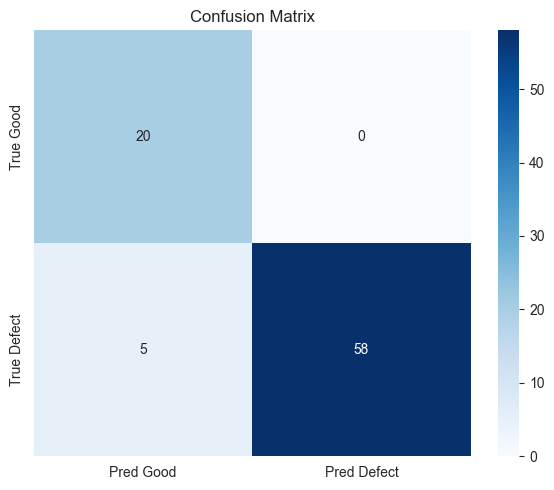

In [41]:
# Hiển thị kết quả inference và đánh giá tổng hợp
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

sns.set_style('whitegrid')

CATEGORIES = ['good', 'broken_large', 'broken_small', 'contamination']
base_dir = pathlib.Path('runs/inference_final')


def parse_results_file(results_file: pathlib.Path):
    records = []
    block = {}

    def flush_block():
        nonlocal block
        if block:
            records.append(block)
            block = {}

    with open(results_file, 'r') as f:
        for raw_line in f:
            clean = raw_line.strip()
            if not clean:
                flush_block()
                continue
            if clean.startswith('Image:'):
                flush_block()
                block = {'image': clean.split('Image:')[1].strip()}
            elif clean.startswith('Predicted:'):
                block['pred'] = clean.split('Predicted:')[1].strip()
            elif clean.startswith('Confidence:'):
                value = clean.split('Confidence:')[1].strip().replace('%', '')
                block['confidence'] = float(value) if value else None
            elif clean.startswith('Prob Good:'):
                value = clean.split('Prob Good:')[1].strip().replace('%', '')
                block['prob_good'] = float(value) if value else None
            elif clean.startswith('Prob Defect:'):
                value = clean.split('Prob Defect:')[1].strip().replace('%', '')
                block['prob_defect'] = float(value) if value else None
        flush_block()
    return records


inference_rows = []
summary_rows = []

for category in CATEGORIES:
    results_path = base_dir / category / 'results.txt'
    if not results_path.exists():
        print(f"⚠️  Không tìm thấy file {results_path}")
        summary_rows.append({
            'category': category,
            'total_images': 0,
            'pred_good': 0,
            'pred_defect': 0,
            'accuracy_%': 0.0
        })
        continue

    parsed = parse_results_file(results_path)
    if not parsed:
        print(f"⚠️  File {results_path} không có dữ liệu")
        continue

    true_label = 'Good' if category == 'good' else 'Defect'
    correct = sum(1 for rec in parsed if rec.get('pred') == true_label)

    for rec in parsed:
        rec['category'] = category
    inference_rows.extend(parsed)

    summary_rows.append({
        'category': category,
        'total_images': len(parsed),
        'pred_good': sum(1 for rec in parsed if rec.get('pred') == 'Good'),
        'pred_defect': sum(1 for rec in parsed if rec.get('pred') == 'Defect'),
        'accuracy_%': round(correct / len(parsed) * 100, 2)
    })

if not inference_rows:
    print('⚠️  Chưa có dữ liệu inference để đánh giá')
else:
    inference_df = pd.DataFrame(inference_rows)
    summary_df = pd.DataFrame(summary_rows)

    print('Tổng quan inference theo category:')
    display(summary_df)

    print('\nMột vài bản ghi mẫu:')
    display(inference_df[['category', 'image', 'pred', 'confidence']].head())

    # Chuẩn bị dữ liệu đánh giá
    eval_df = inference_df.copy()
    eval_df['true'] = eval_df['category'].apply(lambda cat: 'Good' if cat == 'good' else 'Defect')
    eval_df = eval_df.dropna(subset=['pred'])
    eval_df['pred'] = eval_df['pred'].astype(str)
    eval_df['true'] = eval_df['true'].astype(str)

    print(f"\nTổng số mẫu dùng để đánh giá: {len(eval_df)}")
    print(f"  - Good (true): {(eval_df['true'] == 'Good').sum()}")
    print(f"  - Defect (true): {(eval_df['true'] == 'Defect').sum()}")

    # Metrics tổng thể
    accuracy = accuracy_score(eval_df['true'], eval_df['pred'])
    precision = precision_score(eval_df['true'], eval_df['pred'], pos_label='Defect')
    recall = recall_score(eval_df['true'], eval_df['pred'], pos_label='Defect')
    f1 = f1_score(eval_df['true'], eval_df['pred'], pos_label='Defect')

    print('\nOVERALL METRICS')
    print('=' * 60)
    print(f"Accuracy : {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall   : {recall*100:.2f}%")
    print(f"F1-Score : {f1*100:.2f}%")

    # Classification report
    print('\nCLASSIFICATION REPORT')
    print('=' * 60)
    print(classification_report(eval_df['true'], eval_df['pred'], target_names=['Good', 'Defect'], digits=4))

    # Confusion matrix
    cm = confusion_matrix(eval_df['true'], eval_df['pred'], labels=['Good', 'Defect'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Good', 'Pred Defect'], yticklabels=['True Good', 'True Defect'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


### Kết luận
- Lưu lại các artefact: `best_acc.pth`, `best_auc.pth`, `training_curves.png`, `confusion_matrix.png`.
- Có thể mở rộng bằng backbone FPN (`model_type=fpn`) hoặc chỉnh augmentation trong `dataset_loader_balanced.py`.
